In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import (roc_curve, auc, precision_score, recall_score,
                            f1_score, cohen_kappa_score, accuracy_score)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
from sklearn.preprocessing import StandardScaler, label_binarize, RobustScaler

In [2]:
def prepare_data(csv_file):
    df = pd.read_csv(csv_file)
    
    # Convert class labels to numerical
    class_mapping = {name: idx for idx, name in enumerate(df['COMMODITY'].unique())}
    df['label'] = df['COMMODITY'].map(class_mapping)
    
    # Get number of classes
    n_classes = len(class_mapping)
    print(f"Validated {n_classes} classes: {class_mapping}")
    
    # Extract features
    features = df.iloc[:, 1:31].values
    
    # Check for invalid values in training data
    if np.any(~np.isfinite(features)):
        print("Warning: Found NaN or inf in training data. Replacing with zeros.")
        features = np.nan_to_num(features, nan=0.0, posinf=0.0, neginf=0.0)
    
    # Apply StandardScaler
    scaler = StandardScaler()
    
    # Check for zero standard deviation
    scaler.fit(features)
    if np.any(scaler.scale_ == 0):
        print("Warning: Some features have zero standard deviation. Adjusting scale to avoid division by zero.")
        scaler.scale_[scaler.scale_ == 0] = 1.0  # Set scale to 1 for zero-variance features
    
    scaled_features = scaler.transform(features)
    
    # Get target labels
    target = df['label'].values    
    
    return scaled_features, target, n_classes, class_mapping, scaler

In [3]:
def build_rf_model(n_classes, best_params=None):
    default_params = {
        'n_estimators': 200,
        'max_depth': None,  # Let trees grow fully
        'min_samples_split': 5,
        'min_samples_leaf': 2,
        'max_features': 'sqrt',
        'class_weight': 'balanced_subsample',
        'random_state': 42,
        'n_jobs': -1
    }
    if best_params:
        default_params.update(best_params)
    return RandomForestClassifier(**default_params)

In [4]:
def tune_rf_hyperparameters(X, y, n_classes, n_splits=3, n_iter=40):
    """
    Performs randomized search for hyperparameter optimization
    Returns best hyperparameters found
    """
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None],
        'bootstrap': [True, False]
    }

    model = RandomForestClassifier(
        class_weight='balanced',
        random_state=42
    )

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=n_iter,
        scoring='accuracy',
        cv=skf,
        verbose=3,
        random_state=2,
        n_jobs=-1
    )

    search.fit(X, y)
    print(f"\nBest parameters found: {search.best_params_}")
    print(f"Best validation accuracy: {search.best_score_:.3f}")
    return search.best_params_

In [5]:
def bootstrap_train(X, y, n_classes, n_models=10, best_params=None):
    """Train ensemble while preserving all classes in each bootstrap sample"""
    models = []
    class_indices = [np.where(y == c)[0] for c in range(n_classes)]  # Positions of each class
    
    for _ in range(n_models):
        # Create balanced bootstrap sample with all classes
        bootstrap_idx = []
        for indices in class_indices:
            bootstrap_idx.extend(np.random.choice(indices, size=len(indices), replace=True))
        
        X_bootstrap = X[bootstrap_idx]
        y_bootstrap = y[bootstrap_idx]
        
        # Verify we have all classes (sanity check)
        assert len(np.unique(y_bootstrap)) == n_classes, "Missing classes in bootstrap sample"
        
        # Train model
        model = build_rf_model(n_classes, best_params)
        model.fit(X_bootstrap, y_bootstrap)
        models.append(model)
    
    return models


In [6]:
def calculate_metrics(y_true, y_pred, class_names):
    n_classes = len(class_names)
    y_true_binary = label_binarize(y_true, classes=range(n_classes))
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = y_true  # Already integer labels
    
    # Initialize metrics dictionary
    metrics = {
        'Class': class_names,
        'TPR': [],
        'FPR': [],
        'Precision': [],
        'Recall': [],
        'F1 Score': [],
        'AUC': [],
        'Accuracy': []
    }
    
    # Calculate metrics for each class
    for i in range(n_classes):
        # ROC and AUC
        fpr, tpr, _ = roc_curve(y_true_binary[:, i], y_pred[:, i])
        roc_auc = auc(fpr, tpr)
        
        # Calculate binary metrics
        binary_true = (y_true_classes == i).astype(int)
        binary_pred = (y_pred_classes == i).astype(int)
        
        # Store metrics
        metrics['TPR'].append(np.mean(tpr))
        metrics['FPR'].append(np.mean(fpr))
        metrics['Precision'].append(precision_score(binary_true, binary_pred, zero_division=0))
        metrics['Recall'].append(recall_score(binary_true, binary_pred))
        metrics['F1 Score'].append(f1_score(binary_true, binary_pred))
        metrics['AUC'].append(roc_auc)
        metrics['Accuracy'].append(accuracy_score(binary_true, binary_pred))
    
    # Create metrics DataFrame
    metrics_df = pd.DataFrame(metrics)
    
    # Calculate overall Kappa score
    kappa = cohen_kappa_score(y_true_classes, y_pred_classes)
    
    # Calculate and add macro averages
    macro_metrics = {
        'Class': ['Macro Average'],
        'TPR': [np.mean(metrics['TPR'])],
        'FPR': [np.mean(metrics['FPR'])],
        'Precision': [np.mean(metrics['Precision'])],
        'Recall': [np.mean(metrics['Recall'])],
        'F1 Score': [np.mean(metrics['F1 Score'])],
        'AUC': [np.mean(metrics['AUC'])],
        'Accuracy': [np.mean(metrics['Accuracy'])],
        'Kappa': [kappa]
    }
    
    # Add macro averages to DataFrame
    metrics_df = pd.concat([metrics_df, pd.DataFrame(macro_metrics)], ignore_index=True)
    
    # Format metrics to 3 decimal places
    for col in metrics_df.columns:
        if col != 'Class':
            metrics_df[col] = metrics_df[col].apply(lambda x: f"{x:.3f}" if isinstance(x, (int, float)) else x)
    
    # Print formatted table
    print("\nDetailed Classification Metrics:")
    print("-" * 100)
    print(metrics_df.to_string(index=False))
    print("-" * 100)
    print(f"Overall Kappa Score: {kappa:.3f}")
    
    # Save metrics to CSV
    metrics_df.to_csv(r'D:\\Project Rajasthan\\Test\\RandomForest\\RF_classification_metrics.csv', index=False)
    
    return metrics_df, kappa

In [7]:
def plot_roc_curve(y_true, y_pred, class_names):
    n_classes = len(class_names)
    y_true_binarized = label_binarize(y_true, classes=range(n_classes))
    
    fpr = {}
    tpr = {}
    roc_auc = {}

    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        # Corrected line: Use binarized true labels for each class
        fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f"Class {class_names[i]} (AUC = {roc_auc[i]:.3f})")
    
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess (AUC = 0.5)')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - All Classes")
    plt.legend(loc="lower right")
    plt.savefig(r'D:\\Project Rajasthan\\Test\\RandomForest\\ROC_CURVE_RF.png', bbox_inches='tight', dpi=300)

In [8]:
def k_fold_cross_validation(X, y, n_classes, class_names, best_params, n_splits=3):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=2)
    final_y_true = []
    final_y_pred = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        print(f"\nTraining fold {fold + 1}/{n_splits}")
        
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Build and train the model
        model = build_rf_model(n_classes, best_params)
        model.fit(X_train, y_train)
        
        # Predict and store results
        y_pred = model.predict_proba(X_val)
        final_y_true.extend(y_val)
        final_y_pred.extend(y_pred)
    
    # Convert lists to numpy arrays
    final_y_true = np.array(final_y_true)
    final_y_pred = np.array(final_y_pred)
    
    # Plot ROC curves
    plot_roc_curve(final_y_true, final_y_pred, class_names)
    
    # Calculate and display metrics
    metrics_df, kappa = calculate_metrics(final_y_true, final_y_pred, class_names) 
    return metrics_df, kappa

In [9]:
def predict_with_uncertainty(models, X_grid, height, width, class_names, tile_size=100000):
    n_pixels, n_features = X_grid.shape
    n_classes = len(class_names)
    n_models = len(models)

    # Validate input data
    if np.any(~np.isfinite(X_grid)):
        raise ValueError("Input X_grid contains NaN or inf values. Please clean the data before prediction.")

    mean_proba = np.zeros((n_pixels, n_classes), dtype=np.float32)
    std_proba = np.zeros((n_pixels, n_classes), dtype=np.float32)

    for start in range(0, n_pixels, tile_size):
        end = min(start + tile_size, n_pixels)
        tile_data = X_grid[start:end]
        tile_preds = np.zeros((n_models, end - start, n_classes), dtype=np.float32)

        for m_idx, model in enumerate(models):
            tile_preds[m_idx] = model.predict_proba(tile_data)

        tile_mean = tile_preds.mean(axis=0)
        tile_std = tile_preds.std(axis=0)

        mean_proba[start:end] = tile_mean
        std_proba[start:end] = tile_std

    uncertainty = {
        name: std_proba[:, i].reshape(height, width)
        for i, name in enumerate(class_names)
    }

    return mean_proba, uncertainty

In [10]:
def plot_multiclass_maps(predictions, shape, class_names, output_prefix):
    """
    Plot and save prospectivity maps for each class
    """
    n_classes = len(class_names)
    
    # Create a figure with subplots for each class
    fig, axes = plt.subplots(n_classes, 1, figsize=(10, 30))
    
    for idx, (ax, class_name) in enumerate(zip(axes, class_names)):
        class_prob = predictions[:, idx].reshape(shape)
        im = ax.imshow(class_prob, cmap='jet')
        ax.set_title(f'{class_name} Probability(Random Forest)')
        plt.colorbar(im, ax=ax)
    
    plt.tight_layout()
    plt.show()

In [11]:
def save_geotiff_maps(predictions, original_tiff, class_names):
    """
    Save each class probability map as a GeoTIFF
    """
    with rasterio.open(original_tiff) as src:
        original_transform = src.transform
        original_crs = src.crs
        height, width = src.height, src.width

    for idx, class_name in enumerate(class_names):
        class_prob = predictions[:, idx].reshape(height, width)
        
        output_path = f'D:\\Project Rajasthan\\Test\\RandomForest\\{class_name}_probability(RF).tif'
        
        with rasterio.open(
            output_path,
            'w',
            driver='GTiff',
            height=height,
            width=width,
            count=1,
            dtype=class_prob.dtype,
            crs=original_crs,
            transform=original_transform
        ) as dst:
            dst.write(class_prob, 1)

In [12]:
def save_uncertainty_maps(uncertainty_dict, original_tiff, class_names):
    """
    Save single-band uncertainty maps for each commodity
    
    Args:
        uncertainty_dict: {'Copper': 1D_array, 'Gold': 1D_array, ...}
        original_tiff: Reference TIFF for spatial info
        class_names: List of commodity names
    """
    with rasterio.open(original_tiff) as src:
        height, width = src.shape
        profile = {
            'driver': 'GTiff',
            'height': height,
            'width': width,
            'count': 1,  # Single band
            'dtype': 'float32',
            'crs': src.crs,
            'transform': src.transform
        }

    for name in class_names:
        if name not in uncertainty_dict:
            print(f"Skipping {name} - no uncertainty data")
            continue
            
        # Reshape to 2D grid
        data = uncertainty_dict[name].reshape((height, width))
        # Normalize uncertainty (0-1)
        data = (data - data.min()) / (data.max() - data.min())
        with rasterio.open(f'D:\\Project Rajasthan\\Test\\RandomForest\\{name}_Uncertainty.tif', 'w', **profile) as dst:
            dst.write(data, 1)  # Write to band 1


Validated 9 classes: {'COPPER': 0, 'GOLD': 1, 'GRAPHITE': 2, 'IRON': 3, 'LEADZINC': 4, 'LIMESTONE': 5, 'PHOSPHORITE': 6, 'TALCSOAPSTONE': 7, 'NEGATIVE': 8}
Fitting 10 folds for each of 20 candidates, totalling 200 fits


C:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(



Best parameters found: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
Best validation accuracy: 0.955


C:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(



Training fold 1/10

Training fold 2/10

Training fold 3/10

Training fold 4/10

Training fold 5/10

Training fold 6/10

Training fold 7/10

Training fold 8/10

Training fold 9/10

Training fold 10/10

Detailed Classification Metrics:
----------------------------------------------------------------------------------------------------
        Class   TPR   FPR Precision Recall F1 Score   AUC Accuracy Kappa
       COPPER 0.941 0.307     1.000  0.842    0.914 0.994    0.992   nan
         GOLD 0.883 0.132     1.000  1.000    1.000 1.000    1.000   nan
     GRAPHITE 0.632 0.111     1.000  0.667    0.800 0.811    0.997   nan
         IRON 0.939 0.253     0.833  1.000    0.909 1.000    0.989   nan
     LEADZINC 0.928 0.452     1.000  0.867    0.929 0.972    0.983   nan
    LIMESTONE 0.936 0.429     0.815  0.917    0.863 0.988    0.980   nan
  PHOSPHORITE 0.909 0.244     0.952  0.909    0.930 0.992    0.992   nan
TALCSOAPSTONE 0.893 0.347     0.941  0.889    0.914 0.971    0.983   nan
     NE

RandomForestClassifier(bootstrap=False, class_weight='balanced_subsample',
                       min_samples_leaf=2, min_samples_split=5, n_estimators=50,
                       n_jobs=-1, random_state=42)

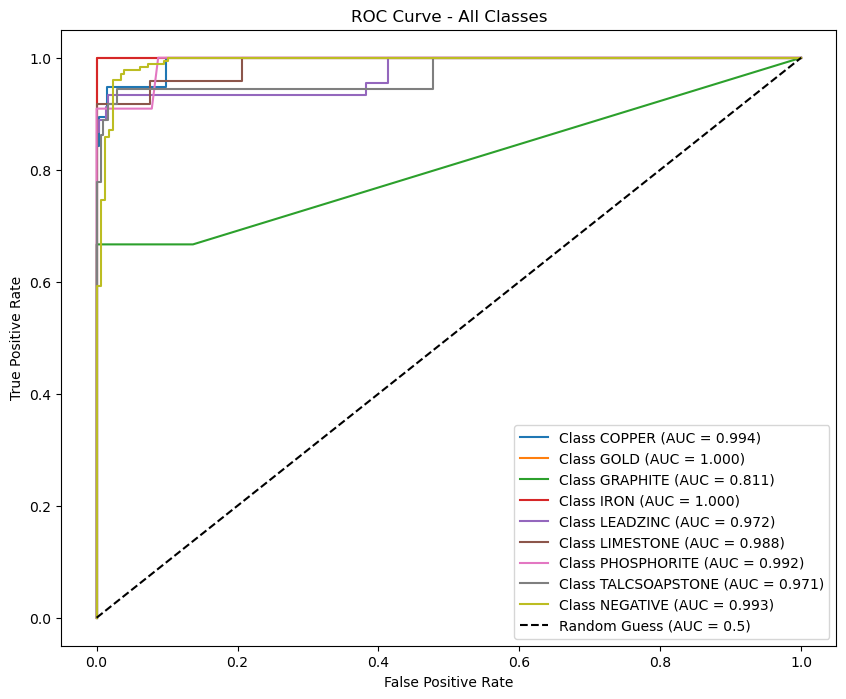

In [13]:
# Load and prepare data
features, target, n_classes, label_encoder, scaler = prepare_data(r"D:\Project Rajasthan\GSI Hackathon 24 Updated\All Factors\Multiclass_Mineral_data.csv")
class_names = list(label_encoder)

# Add hyperparameter tuning
best_params = tune_rf_hyperparameters(
    features, target, n_classes,
    n_splits=10,  # Same as cross-validation splits
    n_iter=20     # Reduce for faster execution
)

ensemble_models = bootstrap_train(features, target, n_classes, n_models=30, best_params=best_params)

# Perform K-Fold Cross Validation
k_fold_cross_validation(features, target, n_classes, class_names, best_params, n_splits=10)

# Build and train the final model
model = build_rf_model(n_classes, best_params)
model.fit(features, target)

In [14]:
org_tiff_loc = r'D:\Project Rajasthan\GSI Hackathon 24 Updated\All Factors\STACK.tif'

with rasterio.open(org_tiff_loc) as stack:
    array = stack.read()
    i, j = array.shape[1], array.shape[2]
    reshaped_data = array.transpose(1, 2, 0).reshape(i * j, array.shape[0])
    
    # Check for invalid values (NaN, inf) in reshaped_data
    if np.any(~np.isfinite(reshaped_data)):
        print("Warning: Found NaN or inf in GeoTIFF data. Replacing with zeros.")
        reshaped_data = np.nan_to_num(reshaped_data, nan=0.0, posinf=0.0, neginf=0.0)
    
    # Check for extreme values (optional, based on domain knowledge)
    max_value_threshold = 1e10  # Adjust based on your data
    min_value_threshold = -1e10
    if np.any(reshaped_data > max_value_threshold) or np.any(reshaped_data < min_value_threshold):
        print("Warning: Found extreme values in GeoTIFF data. Clipping to reasonable range.")
        reshaped_data = np.clip(reshaped_data, min_value_threshold, max_value_threshold)
    
    # Apply scaling
    scaled_grid_data = scaler.transform(reshaped_data)
    
    # Verify scaled data
    if np.any(~np.isfinite(scaled_grid_data)):
        raise ValueError("Scaled data contains NaN or inf after transformation. Check input data or scaler.")

# Predict with memory-efficient method
mean_proba, uncertainty = predict_with_uncertainty(
    ensemble_models,
    scaled_grid_data,
    height=i,
    width=j,
    class_names=class_names,
    tile_size=5000000  # Can adjust for smaller or larger memory
)

save_geotiff_maps(mean_proba, org_tiff_loc, class_names)
save_uncertainty_maps(uncertainty, org_tiff_loc, class_names)

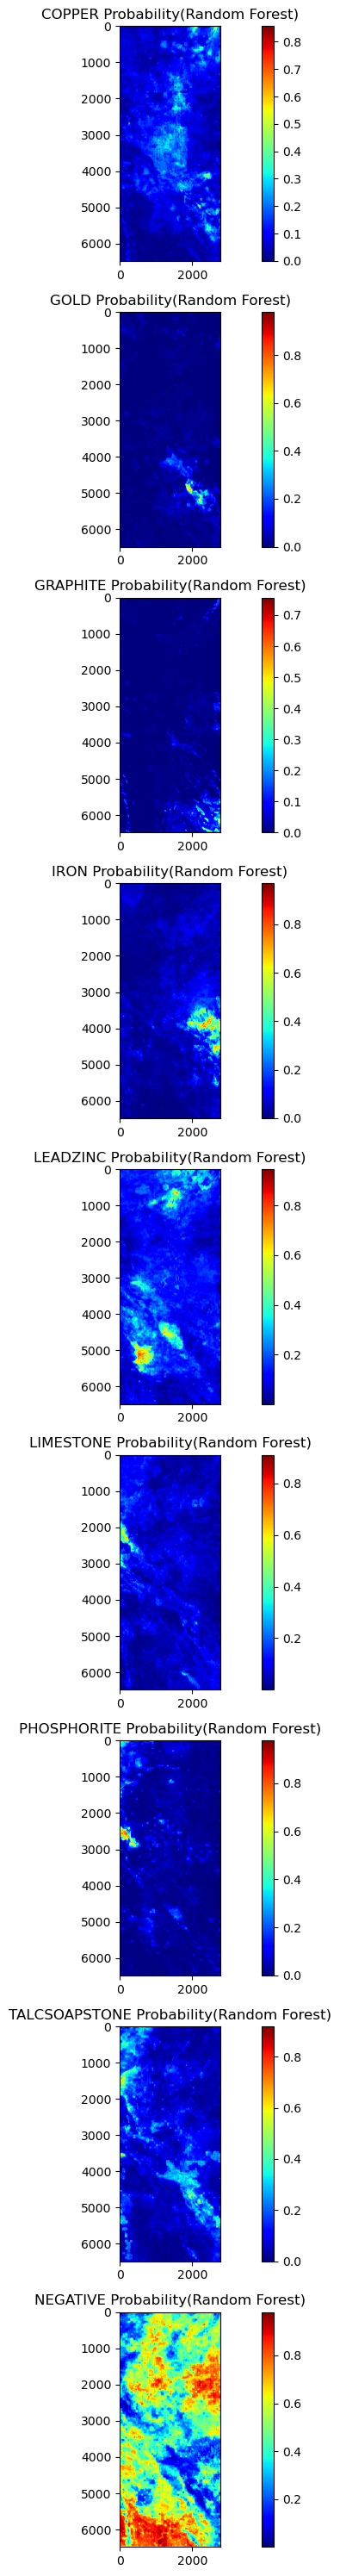

In [15]:
# Plot the prediction maps
plot_multiclass_maps(mean_proba, (i, j), class_names, 'Multiclass')